# Experiment 4.1: Testing the BMT with short, unclipped videos (ActivityNet Captions Dataset)

The aim of this experiment is to evaluate whether the BMT yields an amount of captions consistent with the amount of events found by human annotators. As discussed earlier, the number of annotations in the dataset is subject to the criteria the annotator uses to determine what an event is. This experiment will help us understand the influence of the implicit criteria from annotators in the dataset on the proposal generator module from the BMT. The results will be referenced in further experiments to compare our solution to the original BMT.

## 1. Importing libraries

In [ ]:
# (Optional) Install missing libraries in environment
!pip install pytube

In [ ]:
import json, re, collections
import numpy as np
import matplotlib.pyplot as plt
from pytube import YouTube

## 2. Importing the dataset
In this part, we use the ActivityNet Captions dataset downloadable from https://cs.stanford.edu/people/ranjaykrishna/densevid/.
Download the dataset to your filesystem before executing the following cells.

### 2.1 Train set
The train set will be necessary for some preliminary analysis of the data the BMT was trained on.

In [ ]:
# Replace the value of the following variable with the path to the dataset in your fs.
ANETC_PATH = '/home/A01630791/bmt_clipping_experiments/ActivityNet_Captions'

In [38]:
# Open the file as a JSON object
with open(f'{ANETC_PATH}/train.json', 'r') as f:
    activitynet_train = json.load(f)

In [40]:
# (Optional) Test the above cell printing a sample.
print('sample:', activitynet_train['v_QOlSCBRmfWY'])
print('\nNumber of samples: ', len(activitynet_train))

sample: {'duration': 82.73, 'timestamps': [[0.83, 19.86], [17.37, 60.81], [56.26, 79.42]], 'sentences': ['A young woman is seen standing in a room and leads into her dancing.', ' The girl dances around the room while the camera captures her movements.', ' She continues dancing around the room and ends by laying on the floor.']}

Number of samples:  10009


### 2.2 Validation set
The validation set no. 1 from ActivityNet Captions will be used to feed the BMT in this experiment. We prefer a test dataset. We cannot use it, however, because it doesn't include annotations, hence our choice for a validation subset.

In [6]:
# Open the file as a JSON object
with open(f'{ANETC_PATH}/val_1.json', 'r') as f:
    activitynet_val = json.load(f)

In [15]:
# (Optional) Test the above cell printing a sample.
print('sample:', activitynet_val['v_uqiMw7tQ1Cc'])
print('\nNumber of samples: ', len(activitynet_val))

sample: {'duration': 55.15, 'timestamps': [[0.28, 55.15], [13.79, 54.32]], 'sentences': ['A weight lifting tutorial is given.', '  The coach helps the guy in red with the proper body placement and lifting technique.'], 'video_id': 'uqiMw7tQ1Cc', 'dataset_key': 'v_uqiMw7tQ1Cc'}

Number of samples:  4917


The next cell will download the videos to your filesystem using `pytube`.

In [46]:
# Replace the value of the following variable with the path where you would like to 
#     store the videos.
ANETC_VIDEOS_PATH = '/home/A01630791/bmt_clipping_experiments/ActivityNet_Captions_val_set_videos/'


links = ["https://www.youtube.com/watch?v=" + video_id[2:] for video_id in activitynet_val.keys()]

for link in links: 
    try: 
        yt = YouTube(link) 
    except: 
        print("Error: can't instantiate YouTube objects.") 
      
    filename = re.findall("[^=]+$", link)[0] + '.mp4'
    stream = yt.streams.get_highest_resolution()
    stream.download(output_path=ANETC_VIDEOS_PATH, filename=filename)

print('Download complete.') 

VideoPrivate: jikOPvJPU-c is a private video

## 3. Preparing and pre-analyzing the data

We make this previous analysis to have general view of the data in ActivityNet Captions.
First, we need to convert the data to an array, so it is easier to work with.
The following cell traverses each element in the JSON dataset to reformat them into an array.

In [41]:
# Convert 'activitynet_test' to an array of dictionaries
activitynet_train_list = []

for key in activitynet_train.keys():
    obj = activitynet_train[key]
    obj['video_id'] = key[2:]
    obj['dataset_key'] = key
    activitynet_train_list.append(obj)
    
print('sample:', activitynet_train_list[0])
print('\narr length:', len(activitynet_train_list))

sample: {'duration': 82.73, 'timestamps': [[0.83, 19.86], [17.37, 60.81], [56.26, 79.42]], 'sentences': ['A young woman is seen standing in a room and leads into her dancing.', ' The girl dances around the room while the camera captures her movements.', ' She continues dancing around the room and ends by laying on the floor.'], 'video_id': 'QOlSCBRmfWY', 'dataset_key': 'v_QOlSCBRmfWY'}

arr length: 10009


In [19]:
# Convert 'activitynet_val' to an array of dictionaries
activitynet_val_list = []

for key in activitynet_val.keys():
    obj = activitynet_val[key]
    obj['video_id'] = key[2:]
    obj['dataset_key'] = key
    activitynet_val_list.append(obj)
    
print('sample:', activitynet_val_list[0])
print('\narr length:', len(activitynet_val_list))

sample: {'duration': 55.15, 'timestamps': [[0.28, 55.15], [13.79, 54.32]], 'sentences': ['A weight lifting tutorial is given.', '  The coach helps the guy in red with the proper body placement and lifting technique.'], 'video_id': 'uqiMw7tQ1Cc', 'dataset_key': 'v_uqiMw7tQ1Cc'}

arr length: 4917


### 3.1 Video duration vs. annotations
In this part, we want to see the distribution of annotations over different video durations.

The following cell plots the video duration vs. no. of annotations in the train set.

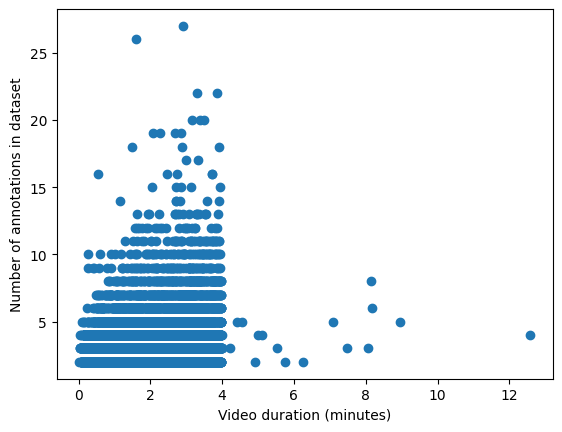

In [44]:
# Sort by video duration
activitynet_train_sorted_duration = sorted(activitynet_train_list, key=lambda i: i['duration'])

# Plot
x = [sample['duration'] / 60 for sample in activitynet_train_sorted_duration]
y = [len(sample['sentences']) for sample in activitynet_train_sorted_duration]

plt.scatter(x, y)

plt.xlabel("Video duration (minutes)")
plt.ylabel("Number of annotations in dataset")

# Save and show
#    Replace the following variable with the path used to save the plot
PLOT_SAVE_PATH = '/home/A01630791/bmt_clipping_experiments/Plots_4_1/'

plt.savefig(f'{PLOT_SAVE_PATH}/3_1_a.png', dpi=300)
plt.show()

The following cell plots the video duration vs. no. of annotations in the validation set.

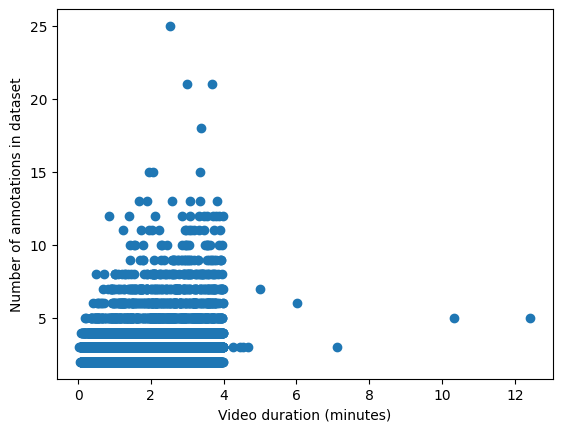

In [45]:
# Sort by video duration
activitynet_val_sorted_duration = sorted(activitynet_val_list, key=lambda i: i['duration'])

# Plot
x = [sample['duration'] / 60 for sample in activitynet_val_sorted_duration]
y = [len(sample['sentences']) for sample in activitynet_val_sorted_duration]

plt.scatter(x, y)

plt.xlabel("Video duration (minutes)")
plt.ylabel("Number of annotations in dataset")

# Save and show
#    Replace the following variable with the path used to save the plot
PLOT_SAVE_PATH = '/home/A01630791/bmt_clipping_experiments/Plots_4_1/'

plt.savefig(f'{PLOT_SAVE_PATH}/3_1_b.png', dpi=300)
plt.show()

If it is true that a longer video contains a greater amount of events, one could expect a greater number of annotations as well. As we can see in the previous two plots, our expectation is not fulfilled. We observe an irregular distribution.